In [212]:
%pip install -qU numpy pandas matplotlib seaborn scikit-learn xgboost alibi

Note: you may need to restart the kernel to use updated packages.


In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [214]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [215]:
df = pd.read_csv('airline_passenger_satisfaction.csv')

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129880 non-null  int64  
 1   Gender                                  129880 non-null  object 
 2   Age                                     129880 non-null  int64  
 3   Customer Type                           129880 non-null  object 
 4   Type of Travel                          129880 non-null  object 
 5   Class                                   129880 non-null  object 
 6   Flight Distance                         129880 non-null  int64  
 7   Departure Delay                         129880 non-null  int64  
 8   Arrival Delay                           129487 non-null  float64
 9   Departure and Arrival Time Convenience  129880 non-null  int64  
 10  Ease of Online Booking                  1298

In [217]:
df['Satisfaction'].value_counts()

Satisfaction
Neutral or Dissatisfied    73452
Satisfied                  56428
Name: count, dtype: int64

In [218]:
df.drop("ID", axis=1, inplace=True)
df.dropna(axis=0, how='any', subset=None, inplace=True)
df['Satisfaction'] = df['Satisfaction'].map({'Neutral or Dissatisfied': 0, 'Satisfied': 1})

In [219]:
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop("Satisfaction", axis=1).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

X = df.drop('Satisfaction', axis=1)
y = df['Satisfaction']


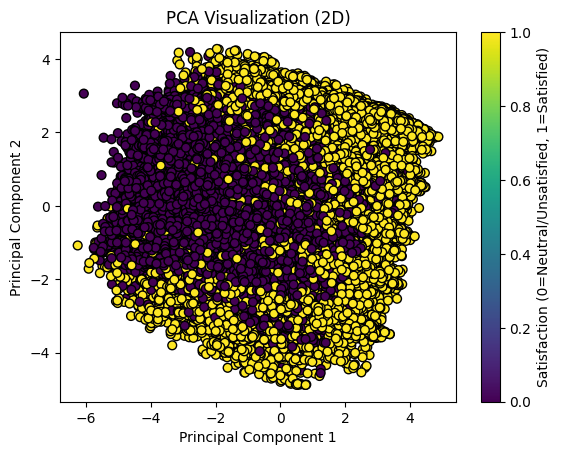

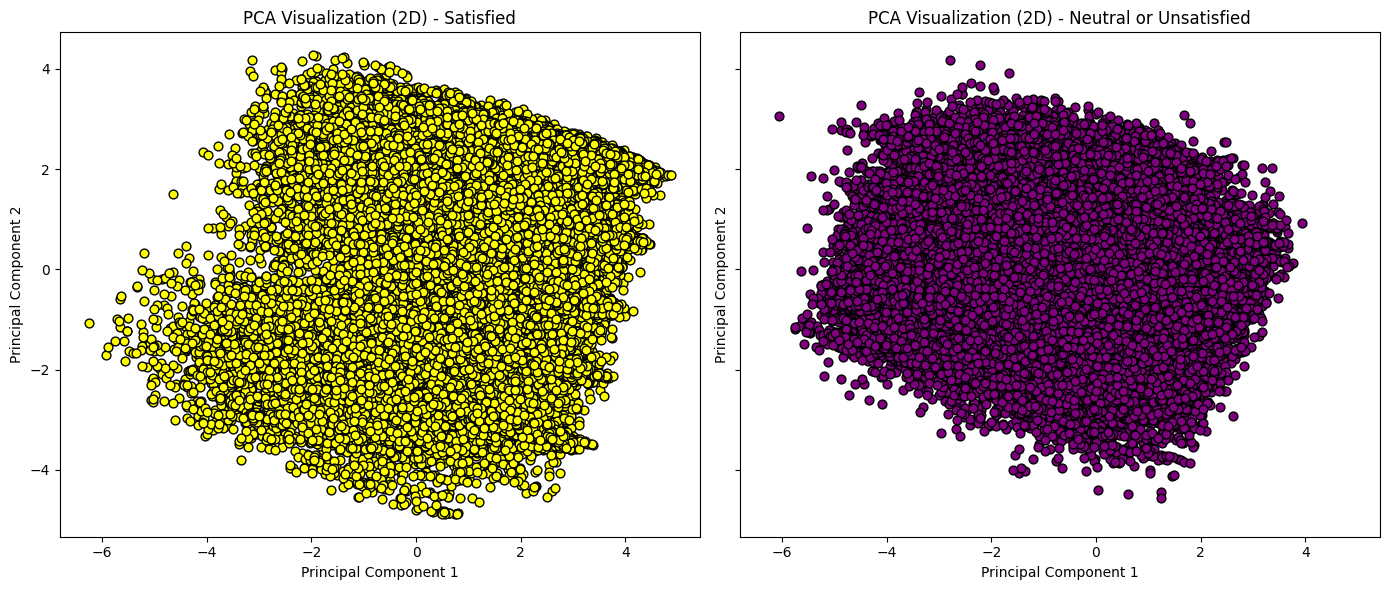

In [220]:

X_processed = preprocessor.fit_transform(X)
#X_processed = preprocessor.fit_transform(df)

pca = PCA(n_components=2)  # Retain 2 components for visualization
X_pca = pca.fit_transform(X_processed)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y,
            cmap='viridis', edgecolor='k', s=40)
plt.title("PCA Visualization (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Satisfaction (0=Neutral/Unsatisfied, 1=Satisfied)')
plt.show()

X_pca_sat = X_pca[df['Satisfaction'] == 1]
X_pca_unsat = X_pca[df['Satisfaction'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)


axes[0].scatter(X_pca_sat[:, 0], X_pca_sat[:, 1], c = "yellow",
             edgecolor='k', s=40)
axes[0].set_title("PCA Visualization (2D) - Satisfied")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
#axes[0].colorbar(label='Satisfaction (0=Neutral/Unsatisfied, 1=Satisfied)')
#plt.show()

axes[1].scatter(X_pca_unsat[:, 0], X_pca_unsat[:, 1], c = 'purple',
            edgecolor='k', s=40)
axes[1].set_title("PCA Visualization (2D) - Neutral or Unsatisfied")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

In [221]:
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=1000, max_iter=1000, n_jobs=-1)

sample_df, _ = train_test_split(df, stratify=df["Satisfaction"], test_size=0.9, random_state=42)

sample_X = sample_df.drop("Satisfaction", axis=1)

sample_X_processed = preprocessor.transform(sample_X)

# Fit and transform the data
X_tsne = tsne.fit_transform(sample_X_processed)



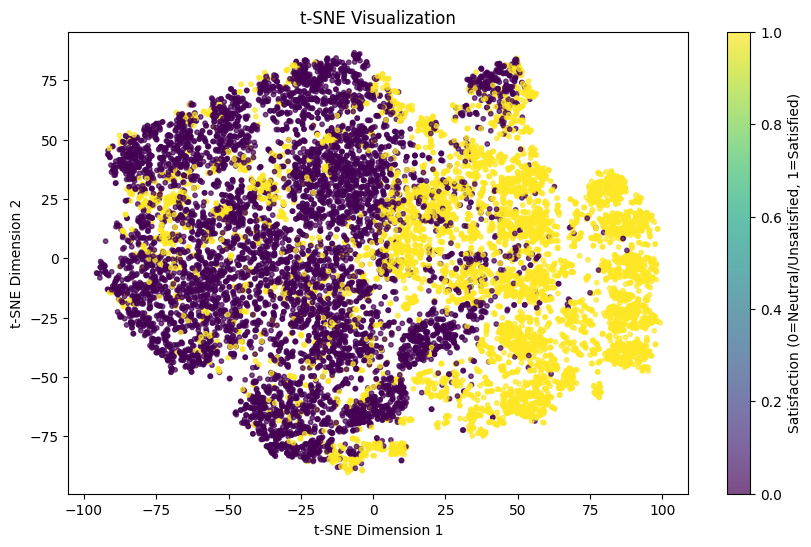

In [222]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sample_df['Satisfaction'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Satisfaction (0=Neutral/Unsatisfied, 1=Satisfied)')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

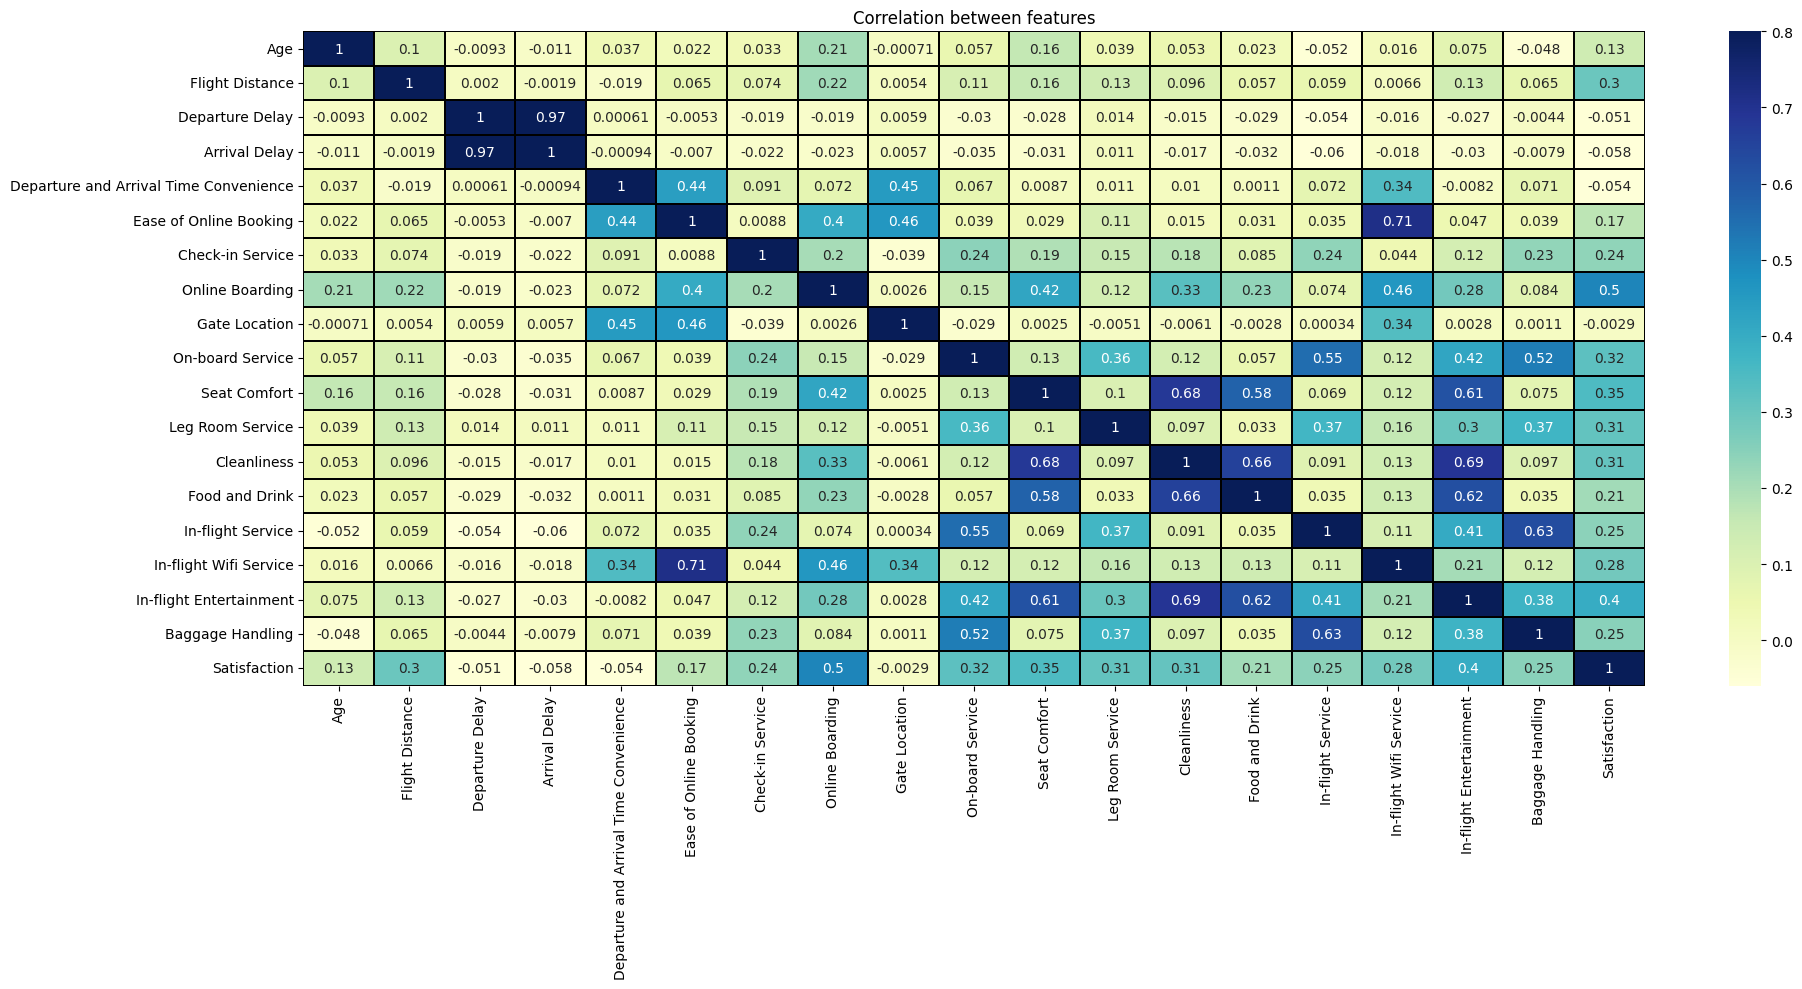

In [223]:
plt.figure(figsize=(20,10))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(),  vmax=0.8, linewidth=0.01, annot = True, cmap='YlGnBu', linecolor ='black')
plt.title('Correlation between features')
plt.tight_layout()
plt.savefig("correlation.png")

Accuracy: 0.884508456251448
Confusion Matrix:
[[12711  1974]
 [ 1017 10196]]


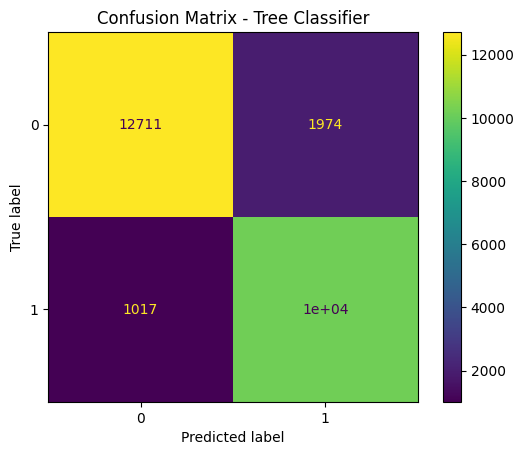

In [224]:
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)

# Step 4: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# Step 5: Create a pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('classifier', tree_clf)
])

# Step 6: Train the classifier
model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix - Tree Classifier')
plt.show()

In [225]:
def plot_decision_tree(decision_tree):
    plt.figure(figsize=(12, 8))
    plot_tree(decision_tree, feature_names=df.columns, class_names=['Unsatisfied/Neutral', 'Satisfied'], filled=True)
    plt.title("Decision Tree Visualization")
    plt.savefig("decision_tree.png")
    plt.show()

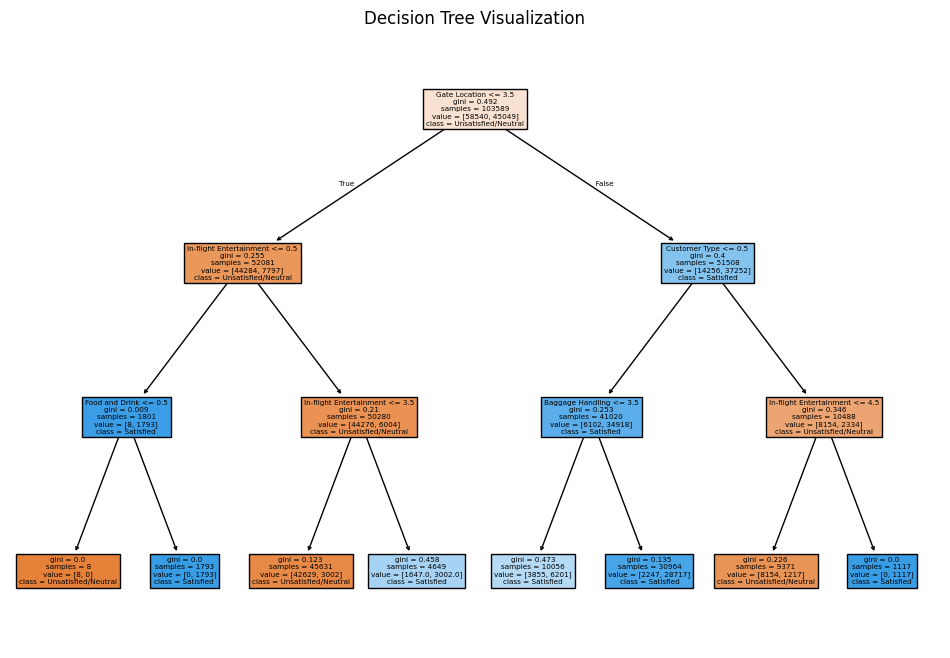

In [226]:
plot_decision_tree(tree_clf)

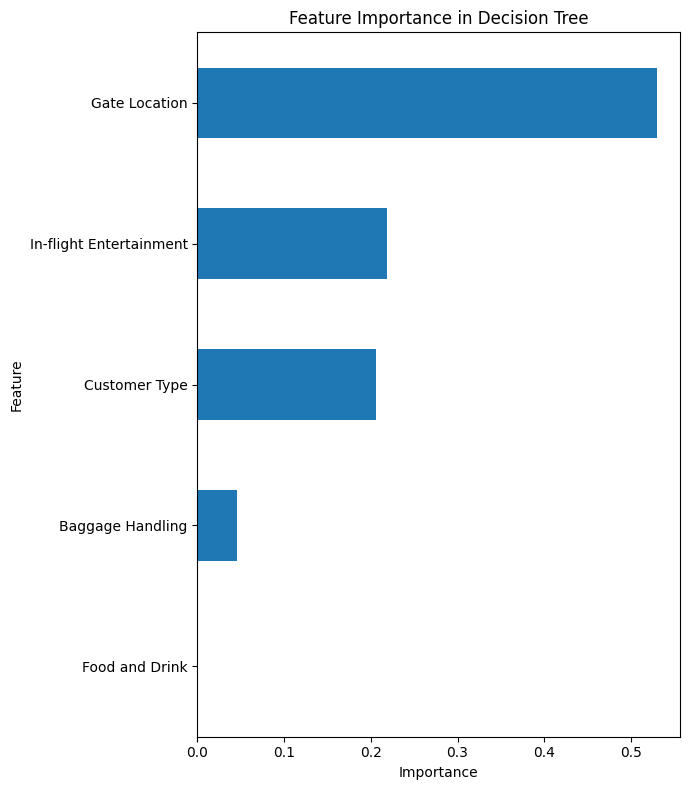

In [227]:
# Feature importance
importances = pd.Series(tree_clf.feature_importances_, index=df.columns)
importances = importances[importances > 0]
importances =importances.sort_values() 
importances.plot(kind='barh',figsize=(7,8))
plt.title("Feature Importance in Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importance.png")

/home/minipoloalex/Documents/TAAC/XAI-techniques/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:47:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9632404046644528
Confusion Matrix:
 [[14353   332]
 [  620 10593]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     14685
           1       0.97      0.94      0.96     11213

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898



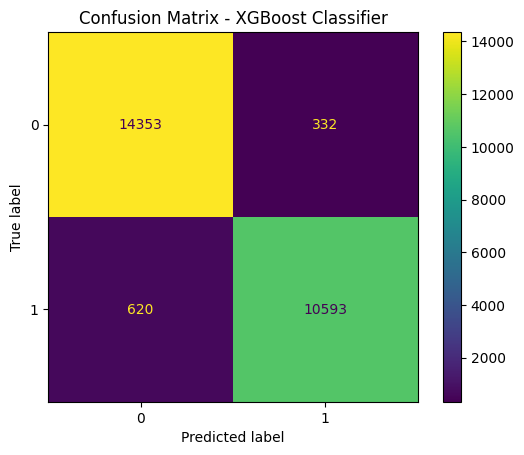

In [228]:
import xgboost as xgb

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline with preprocessor and XGBoost classifier
black_box_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', black_box_model)
])

# Fit the model on the training data
model_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()

## Simplification-based XAI techniques
### Surrogate Model

In [229]:
black_box_pipeline = model_pipeline

# Define the pipeline with preprocessor and XGBoost classifier
surrogate_model = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', surrogate_model),
])

y_train_surrogate = black_box_pipeline.predict(X_train)

surrogate_pipeline.fit(X_train, y_train_surrogate)

y_pred_surrogate = surrogate_pipeline.predict(X_test)

print("Agreement Rate (Accuracy):", accuracy_score(y_true=y_pred, y_pred=y_pred_surrogate))
print("Confusion Matrix:\n", confusion_matrix(y_true=y_pred, y_pred=y_pred_surrogate))
print("Classification Report:\n", classification_report(y_true=y_pred, y_pred=y_pred_surrogate))

Agreement Rate (Accuracy): 0.8966329446289288
Confusion Matrix:
 [[13012  1961]
 [  716 10209]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91     14973
           1       0.84      0.93      0.88     10925

    accuracy                           0.90     25898
   macro avg       0.89      0.90      0.90     25898
weighted avg       0.90      0.90      0.90     25898



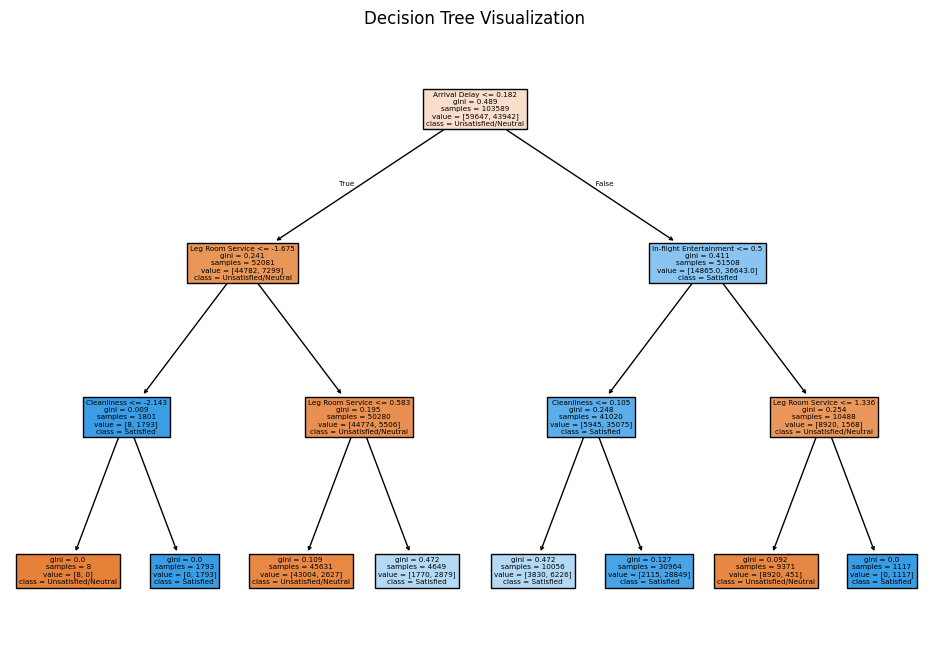

In [230]:
plot_decision_tree(surrogate_model)

In [231]:
from sklearn.tree import export_text
from IPython.display import Markdown

print("Surrogate Model Rules:\n")
print(export_text(surrogate_model, feature_names=df.columns))

Surrogate Model Rules:

|--- Arrival Delay <= 0.18
|   |--- Leg Room Service <= -1.68
|   |   |--- Cleanliness <= -2.14
|   |   |   |--- class: 0
|   |   |--- Cleanliness >  -2.14
|   |   |   |--- class: 1
|   |--- Leg Room Service >  -1.68
|   |   |--- Leg Room Service <= 0.58
|   |   |   |--- class: 0
|   |   |--- Leg Room Service >  0.58
|   |   |   |--- class: 1
|--- Arrival Delay >  0.18
|   |--- In-flight Entertainment <= 0.50
|   |   |--- Cleanliness <= 0.11
|   |   |   |--- class: 1
|   |   |--- Cleanliness >  0.11
|   |   |   |--- class: 1
|   |--- In-flight Entertainment >  0.50
|   |   |--- Leg Room Service <= 1.34
|   |   |   |--- class: 0
|   |   |--- Leg Room Service >  1.34
|   |   |   |--- class: 1



## Example-based XAI Techniques
### ...

In [232]:
# from alibi.explainers import AnchorTabular
# from alibi.utils import gen_category_map
# feature_names = X.columns.to_list()

# def predict_fn(x):
#     print(x)
#     return black_box_model.predict(preprocessor.transform(x))


# # print('Train accuracy: ', accuracy_score(y_train, predict_fn(X_train)))
# # print('Test accuracy: ', accuracy_score(y_test, predict_fn(X_test)))

# cat_map = gen_category_map(df)
# print(cat_map)
# # print(predict_fn(X_test.iloc[[0]]))
# # print(X.columns.to_list())
# print(feature_names)
# print(len(feature_names))
# anchor_explainer = AnchorTabular(predict_fn, feature_names=feature_names, ohe=True, categorical_names=cat_map)

In [233]:
# anchor_explainer.fit(X_train, disc_perc=[25, 50, 75])

In [234]:
# def show_anchor(anchor_explanation):
#     print(f"Anchor: {" AND ".join(anchor_explanation.anchor)}")
#     print(f"Precision: {anchor_explanation.precision}")
#     print(f"Coverage: {anchor_explanation.coverage:.3f}")

In [235]:
# idx = 0
# anchor_explanation = anchor_explainer.explain(X_test[idx], threshold=0.95)
# show_anchor(anchor_explanation)

### Dice

In [236]:
import dice_ml
from dice_ml.utils import helpers  # helper functions

In [237]:
d = dice_ml.Data(
    dataframe=df,
    continuous_features=["Age", "Flight Distance", "Departure Delay", "Arrival Delay"],
    outcome_name="Satisfaction",
)
m = dice_ml.Model(model=model_pipeline, backend="sklearn")

satisfied = X_train[y_train == 1]
unsatisfied = X_train[y_train == 0]

In [238]:
features_to_vary = X.columns.drop(["Gender", "Age"]).to_list()
features_to_vary

['Customer Type',
 'Type of Travel',
 'Class',
 'Flight Distance',
 'Departure Delay',
 'Arrival Delay',
 'Departure and Arrival Time Convenience',
 'Ease of Online Booking',
 'Check-in Service',
 'Online Boarding',
 'Gate Location',
 'On-board Service',
 'Seat Comfort',
 'Leg Room Service',
 'Cleanliness',
 'Food and Drink',
 'In-flight Service',
 'In-flight Wifi Service',
 'In-flight Entertainment',
 'Baggage Handling']

In [239]:
query_instances = [satisfied.iloc[[0]]] + [unsatisfied.iloc[[0]]]

In [240]:
def show_counterfactuals(exp):
    dice_exp = exp.generate_counterfactuals(
        query_instances,
        total_CFs=5,
        desired_class="opposite",
        verbose=False,
        features_to_vary=features_to_vary,
    )
    return dice_exp.visualize_as_dataframe(show_only_changes=True)

In [241]:
exp_random = dice_ml.Dice(d, m, method="random")
show_counterfactuals(exp_random)

100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


Query instance (original outcome : 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,37,Returning,Business,Business,2060,0,0.0,5,5,...,5,4,5,3,2,5,5,5,5,1



Diverse Counterfactual set (new outcome: 0)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,-,-,-,-,-,-,-,-,-,0,...,-,-,-,-,-,-,1,-,2,0
1,-,-,First-time,-,-,-,-,-,-,-,...,-,-,-,-,0,-,2,-,-,0
2,-,-,First-time,-,-,-,-,-,-,-,...,-,-,-,-,-,-,1,-,-,0
3,-,-,-,Personal,-,-,-,-,-,-,...,-,-,-,-,-,-,4,-,-,0
4,-,-,First-time,-,-,-,-,-,-,-,...,2,-,-,-,-,-,4,-,-,0


Query instance (original outcome : 0)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,38,Returning,Business,Business,564,0,0.0,2,2,...,1,4,1,4,5,1,1,1,1,0



Diverse Counterfactual set (new outcome: 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,5,-,-,-,-,-,1
1,-,-,-,-,-,-,-,-,-,-,...,-,5,-,-,-,-,-,-,4,1
2,-,-,-,-,-,-,-,-,-,-,...,5,-,-,5,-,-,-,-,-,1
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,0,-,-,5,-,-,1
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,5,-,-,1


In [242]:
exp_genetic = dice_ml.Dice(d, m, method='genetic')
show_counterfactuals(exp_genetic)

100%|██████████| 2/2 [00:05<00:00,  2.82s/it]

Query instance (original outcome : 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,37,Returning,Business,Business,2060,0,0.0,5,5,...,5,4,5,3,2,5,5,5,5,1



Diverse Counterfactual set (new outcome: 0)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,-,-,-,-,-,-,-,-,2,2,...,-,-,4,1,5,-,-,-,-,0
0,-,-,-,Personal,-,-,-,-,-,3,...,-,1,-,1,1,1,3,1,-,0
0,-,-,First-time,-,-,-,-,-,-,-,...,-,-,-,1,4,3,1,3,3,0
0,-,-,-,-,-,-,-,-,0,0,...,-,2,0,-,1,-,1,-,-,0
0,-,-,First-time,-,Economy,-,-,-,-,-,...,4,5,-,-,-,2,1,3,3,0


Query instance (original outcome : 0)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,38,Returning,Business,Business,564,0,0.0,2,2,...,1,4,1,4,5,1,1,1,1,0



Diverse Counterfactual set (new outcome: 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,-,-,-,-,-,31,-,-,4,-,...,-,-,-,-,2,4,5,5,-,1
0,-,-,-,-,-,-,-,-,1,1,...,-,-,3,-,4,-,-,4,4,1
0,-,-,-,-,-,-,-,-,-,-,...,5,-,4,-,4,5,2,4,5,1
0,-,-,-,-,-,31,-,-,3,-,...,2,3,4,3,4,4,4,-,-,1
0,-,-,-,-,-,-,-,-,-,4,...,-,-,3,3,3,-,-,4,4,1


In [243]:
exp_KD = dice_ml.Dice(d, m, method='kdtree')
show_counterfactuals(exp_KD)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

Query instance (original outcome : 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,37,Returning,Business,Business,2060,0,0.0,5,5,...,5,4,5,3,2,5,5,5,5,1



No counterfactuals found!
Query instance (original outcome : 0)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,38,Returning,Business,Business,564,0,0.0,2,2,...,1,4,1,4,5,1,1,1,1,0



Diverse Counterfactual set (new outcome: 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
65897,-,-,-,-,-,-,-,-,3,3,...,4,-,4,5,2,4,3,4,4,1
